In [9]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe

loading Dark matter..
dm 3.09695e-08 1.0
dm 0.000774369 25004.2
dm 0.000774369 25004.2
DMDM  0.000774369 25004.2
computing virial radius (r200)


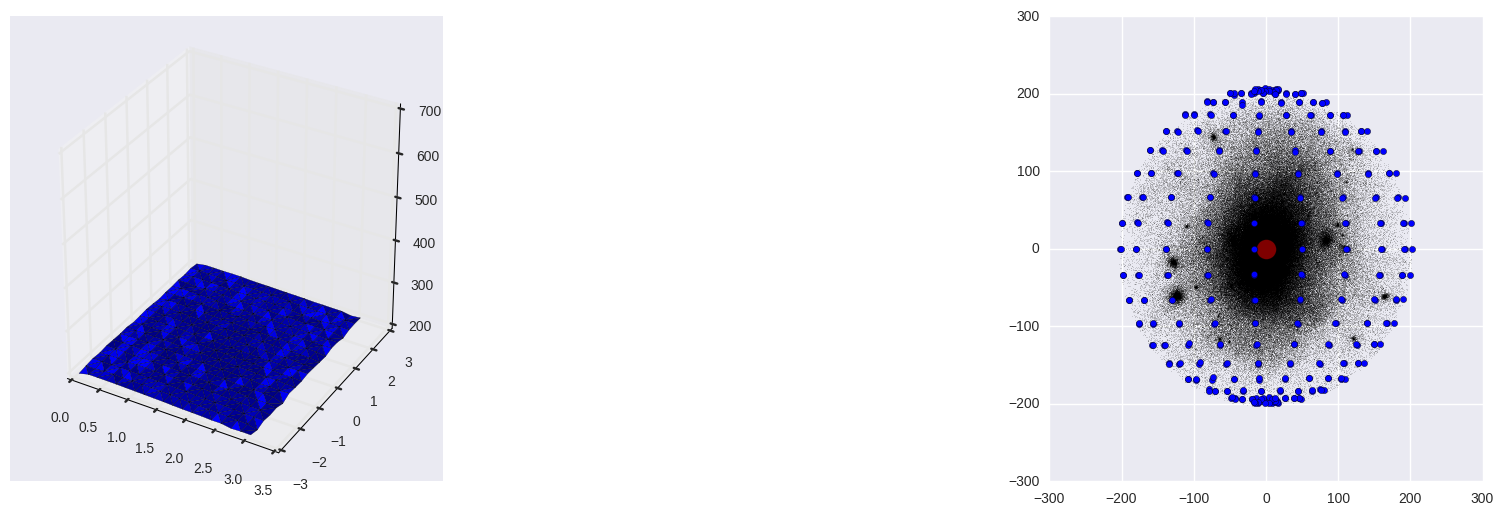

In [10]:
def end_point(num):
    path = "/media/arturo/ARTUROTECA/TMP/tubach5Hydro/box25Mpc_4zoom_turbach_halo5_hydro/output_000"   
    #path = "/data/MIB/anunez/NewSchool/Turbach/box25Mpc_4zoom_turbach_halo5_hydro/output_000"
    num="41"
    p =  nbe.Info_sniffer(path+num)
    myhalo = wkbl.Galaxy_Hound(path+num,"halo")
    #myhalo = wkbl.astro._dark_matter._dark_matter(path,p)
    print "computing virial radius (r200)"
    myhalo.r_virial(300,n=1)
    myhalo.center_shift(nbe.get_com(myhalo.dm.pos3d,myhalo.dm.mass))
    
    
    x = myhalo.dm.pos3d[:,0]
    y = myhalo.dm.pos3d[:,1]
    z = myhalo.dm.pos3d[:,2]
    r = sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(x,y)
    theta = np.arccos(z/r)
    t_secs = np.linspace(0,np.pi,20)
    p_secs = np.linspace(-np.pi,np.pi,20)
    cage = []
    for i in range(len(p_secs)-1):
        for j in range(len(t_secs)-1):
            con_phi =(phi>= p_secs[i])&(phi< p_secs[i+1])
            con_the =(theta>= t_secs[j])&(theta< t_secs[j+1])
            try:
                localmax = np.max(r[con_phi&con_the])
                p = p_secs[i] + (p_secs[i+1]-p_secs[i])/2.
                t = t_secs[j] + (t_secs[j+1]-t_secs[j])/2.
                cage.append([t,p,localmax])
            except:
                continue
    cage = np.array(cage)
    fig = plt.figure(figsize=[19,6])
    ax = fig.add_subplot(131, projection='3d')        
    ax.set_zlim([200,700])
    ax.plot_trisurf(cage[:,0],cage[:,1],cage[:,2],linewidth=0.2, antialiased=True)
    
    #return myhalo.dm.id
    xi = cage[:,2]*np.sin(cage[:,0])*np.cos(cage[:,1])
    yi = cage[:,2]*np.sin(cage[:,0])*np.sin(cage[:,1])
    zi = cage[:,2]*np.cos(cage[:,0])
    ax = fig.add_subplot(133)
    ax.scatter(x, y, s=0.1, c='k', lw=0, alpha=0.5 )
    ax.scatter(myhalo.center[0],myhalo.center[2],s=200,c='r',alpha=0.5)
    ax.scatter(xi,zi)
    return myhalo.dm.id, myhalo.r200


part_id, r200 = end_point("41")

loading Dark matter..
dm 2.64794e-07 1.0
dm 0.00661984 25000.0
dm 0.00661984 25000.0
DMDM  0.00661984 25000.0
H =  67.7399978638 a =  0.850209866944 r200= 235.236037331
6.19798224014
clump info
mean = 17.9185612488 sigma = 27.2104424337
clumps out of the resevation =  4 , points making the cage = 361
---- escaped halos = 5
---- escaped halos = 2
---- escaped halos = 1
---- escaped halos = 3
computing virial radius of all 12 escaped clumps
plotting


0

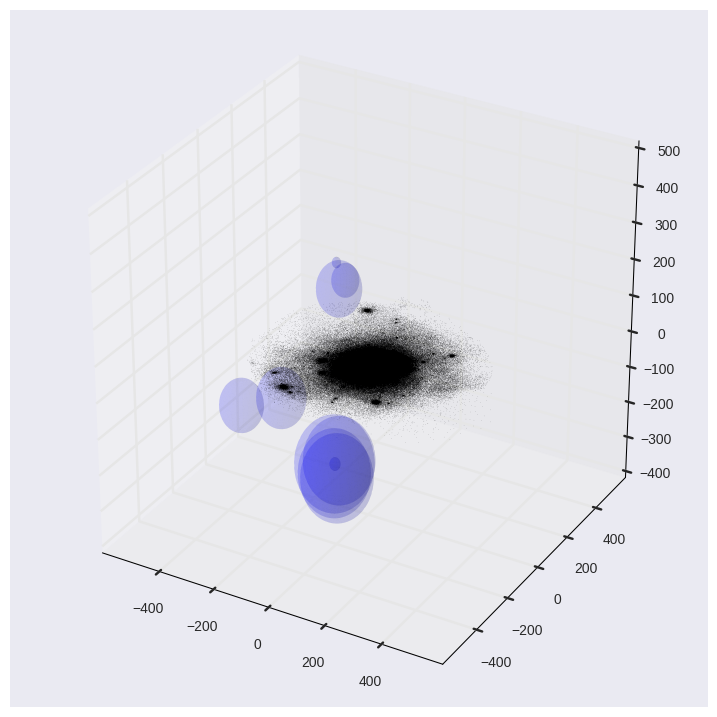

In [40]:
num = "33"
#par_ids = myhalo.dm.id
def get_it(par_ids,num,r200):
    path = "/media/arturo/ARTUROTECA/TMP/tubach5Hydro/box25Mpc_4zoom_turbach_halo5_hydro/output_000"   
    #path = "/data/MIB/anunez/NewSchool/Turbach/box25Mpc_4zoom_turbach_halo5_hydro/output_000"
    p =  nbe.Info_sniffer(path+num)
    h_40 = wkbl.Galaxy_Hound(path+num,"halo",comov=True)
    par_ids=part_id
    #h_40.r_virial(300,n=1)
    h_40.center_shift(nbe.get_com(h_40.dm.pos3d,h_40.dm.mass))
    in_halo = np.where(np.in1d(h_40.dm.id,par_ids))[0]
    cho_pos3d = h_40.dm.pos3d[in_halo]
    cho_mass = h_40.dm.mass[in_halo]
    cho_id = h_40.dm.id[in_halo]
    h_40.center_shift(nbe.get_com(cho_pos3d,cho_mass))
    cho_pos3d = h_40.dm.pos3d[in_halo]
    #cho_pos3d = cho_pos3d - nbe.get_com(cho_pos3d,cho_mass)
    h_40.center_shift(nbe.get_com(cho_pos3d,cho_mass))
        
        
    #############################
        
    x = cho_pos3d[:,0]
    y = cho_pos3d[:,1]
    z = cho_pos3d[:,2]
    r = sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(x,y)
    theta = np.arccos(z/r)
    t_secs = np.linspace(0,np.pi,20)
    p_secs = np.linspace(-np.pi,np.pi,20)
    cage = []
    def rho_box(r,p,t,m_tot):
        V  = (r[0]**3 - (r[0]-r[1])**3)*(np.cos(t[0])-np.cos(t[1]))*(p[1]-p[0])
    
        return m_tot / V / 3. 
    
    print "H = ", h_40.p.H0,"a = ", h_40.p.aexp,"r200=", 200. / h_40.p.aexp
          
        
    densities = []
    for i in range(len(p_secs)-1):
        for j in range(len(t_secs)-1):
            con_phi = (phi>= p_secs[i])&(phi< p_secs[i+1])
            con_the = (theta>= t_secs[j])&(theta< t_secs[j+1])
    
        
        
            #try:
            localmax = np.max(r[con_phi&con_the])
            Dr = localmax - r200
            con_r =(r>= localmax-Dr)&(theta<localmax )
            m_tot = np.sum(cho_mass[con_phi&con_the&con_r])
            p = p_secs[i] + (p_secs[i+1]-p_secs[i])/2.
            t = t_secs[j] + (t_secs[j+1]-t_secs[j])/2.
            cage.append([t,p,localmax])
            densities.append(rho_box([localmax,Dr],[p_secs[i],p_secs[i+1]],
                                        [t_secs[j],t_secs[j+1]],m_tot))
            #except:
            #    continue
        
    cage = np.array(cage)
    densities = np.array(densities)
    ######### clumps #########
    C = h_40.dm.Clumps
    a = C.pos3d
    
    print np.min(np.sqrt(h_40.dm.Clumps.pos3d[:,0]**2+h_40.dm.Clumps.pos3d[:,1]**2+h_40.dm.Clumps.pos3d[:,2]**2))
    if len(densities)>0:
        rho_d = densities / np.max(densities)
        RR = np.sqrt(C.pos3d[:,0]**2+C.pos3d[:,1]**2+C.pos3d[:,2]**2)
        c_in_halo = nbe.all_inside(C.pos3d, h_40.center, cage[:,2].max())
        C.pos3d = C.pos3d[c_in_halo]
        C.mass = C.mass[c_in_halo]
        C_pos = C.pos3d[np.argsort(C.mass)][0:-3]
        C_mass = C.mass[np.argsort(C.mass)][0:-3]    
        c_r = np.sqrt((C_pos[:,0]**2) + (C_pos[:,1]**2) + (C_pos[:,2]**2))
        C_pos = C_pos[(c_r >r200)]
        C_mass = C_mass[(c_r >  r200)]
        c_r = np.sqrt((C_pos[:,0]**2) + (C_pos[:,1]**2) + (C_pos[:,2]**2))
        m_prim = []
        for i in c_r:
            m_prim.append(np.sum(cho_mass[(r < i)]) / (4. * np.pi * (i**3) / 3.))
        m_prim = np.array(m_prim)
        
    
        virs = np.array([])
        print "clump info"
        mean = np.mean(cage[:,2]*rho_d)
        sigma = np.std(cage[:,2]*rho_d)
        print "mean =",mean,"sigma =", sigma
        out = cage[np.where(cage[:,2]*rho_d > 3*sigma)]
        print "clumps out of the resevation = ", len(out),", points making the cage =", len(cage)
        clumps_pos = np.array([0,0,0])
        clumps_vir = np.array([])
        clumps_mass = np.array([])
        clumps_phi = np.arctan2(C_pos[:,0],C_pos[:,1])
        clumps_theta = np.arccos(C_pos[:,2]/c_r)
        for i in range(len(out)):
            dphi = np.pi/20.
            dtheta = np.pi/40.
            con_phi = (clumps_phi>=out[i,1]-dphi)&(clumps_phi<out[i,1]+dphi)
            con_theta = (clumps_theta>=out[i,0]-dtheta)&(clumps_theta<out[i,0]+dtheta)
            con_r = (c_r> r200)&(c_r<cage[:,2].max())
            print "---- escaped halos =", len(C_pos[con_phi&con_theta&con_r])
            clumps_pos = np.vstack((clumps_pos, C_pos[con_phi&con_theta&con_r]))
            clumps_mass = np.append(clumps_mass, C_mass[con_phi&con_theta&con_r])
            
        c_c = clumps_pos
        print "computing virial radius of all {0} escaped clumps".format(len(c_c))
        for i in range(len(c_c)):
            r_min= 0
            r_tmp = np.sqrt((cho_pos3d[:,0]-c_c[i,0])**2 + (cho_pos3d[:,1]-c_c[i,1])**2 +(cho_pos3d[:,2]-c_c[i,2])**2)
            r = r_tmp[np.argsort(r_tmp)]
            mass_c = cho_mass[np.argsort(r_tmp)]
            rho_local = 2 * m_prim[i]
            j =  np.where(r>r_min)[0][0]
            if r_min==0:
                msu = 0
            else:
                msu = np.sum(mass_sorted[j-1])
            try:
                while rho_local >  m_prim[i]:
                    msu += mass_c[j]
                    rho_local =  (3. /4. / np.pi) * msu / (r[j]**3)
                    j+=1
            except:
                print "virial radius did not converged "
                sys.exit()
            virs = np.append(virs,r[j])
        clumps_vir = virs
        ##### computing merging halos
            
    ##### saving recovered halos
    # check id repeated
    clumps_pos = clumps_pos[np.argsort(clumps_vir)]
    clumps_vir = clumps_vir[np.argsort(clumps_vir)]
    for i in range(len(clumps_vir)-2):
        if len(clumps_pos[i+1:])==0:
            continue
        
        tree = KDTree(clumps_pos[i+1:])
        inside = tree.query_radius(clumps_pos[i],clumps_vir[i])
        if len(inside)>0:
            for j in range(len(inside)):
                u=2
                #clumps_pos = np.delete(clumps_pos, inside[j], 0)
                #clumps_vir = np.delete(clumps_vir, inside[j], 0)
                
            
            
        

            
    ##### Plotting
    print "plotting"
    fig = plt.figure(figsize=[9,9])
    #ax = fig.add_subplot(131, projection='3d')
    #label_size = 15
    #ax.set_xlabel(r'$ \theta $ ',fontsize = label_size)
    #ax.set_ylabel(r'$ \phi $ ',fontsize = label_size)
    #ax.set_zlabel(r'$ r_{cage} $ ',fontsize = label_size+4)

    #if len(densities)>0:
    #    ax.plot_trisurf(cage[:,0],cage[:,1],cage[:,2],linewidth=0.2, antialiased=True)
    #    ax.set_zlim([200,700])
    #ax = fig.add_subplot(132, projection='3d')
    #ax.set_xlabel(r'$ \theta $ ',fontsize = label_size)
    #ax.set_ylabel(r'$ \phi $ ',fontsize = label_size)
    #ax.set_zlabel(r'$ \frac{\rho}{n_{\rho}}r_{cage}$ ',fontsize = label_size+4)
        
    #ax.set_title("output_000"+num)
    #if len(densities)>0:    
    #    ax.plot_trisurf(cage[:,0],cage[:,1],cage[:,2]*rho_d,linewidth=0.2, antialiased=True)
    #    yi = cage[:,2]*np.sin(cage[:,0])*np.cos(cage[:,1])
    #    xi = cage[:,2]*np.sin(cage[:,0])*np.sin(cage[:,1])
    #    zi = cage[:,2]*np.cos(cage[:,0])
    #    # above center
    #    y_above = yi[(xi>0)]
    #    z_above = zi[(xi>0)]
    #    # below center
    #    y_below = yi[(xi<0)]
    #    z_below = zi[(xi<0)]
        
        
    ax = fig.add_subplot(111,projection='3d')
        
    
    
    ax.set_xlim([-500/h_40.p.aexp,500/h_40.p.aexp])
    ax.set_ylim([-500/h_40.p.aexp,500/h_40.p.aexp])
    ax.scatter(y,z, s=0.1, c='k', lw=0, alpha=0.5 )
    #ax.scatter(C_pos[:,1],C_pos[:,2])
    # plot center point
    ax.scatter( h_40.center[1],h_40.center[2],s=200,c='r',alpha=0.5)
    if len(densities)>0:
        # find and plot peaks in cage
        y_out = out[:,2]*np.sin(out[:,0])*np.cos(out[:,1])
        x_out = out[:,2]*np.sin(out[:,0])*np.sin(out[:,1])
        z_out = out[:,2]*np.cos(out[:,0])
        for k in range(len(clumps_vir)):
            if clumps_vir[k] > r200:
                continue
            #circle = plt.Circle((clumps_pos[k,1],clumps_pos[k,2]),
            #                    clumps_vir[k],color='m',lw=1, alpha=.1)
            s = sphere(clumps_vir[k],clumps_pos[k])
            ax.plot_surface(s[0], s[1], s[2],  rstride=4, cstride=4, color='b',
                linewidth=0, alpha=0.1)

        
    # plot circe with r200
    #circle = plt.Circle((h_40.center[0],h_40.center[2]),
    #                   r200,color='r',lw=1, alpha=.1)
    #ax.add_patch( circle )
    fig.savefig('/home/arturo/Documents/LAM/SIM_Movies/clump_follow_imgs/clump_'+num+'.png', dpi=fig.dpi)
    return 0

get_it(part_id,"35",r200)

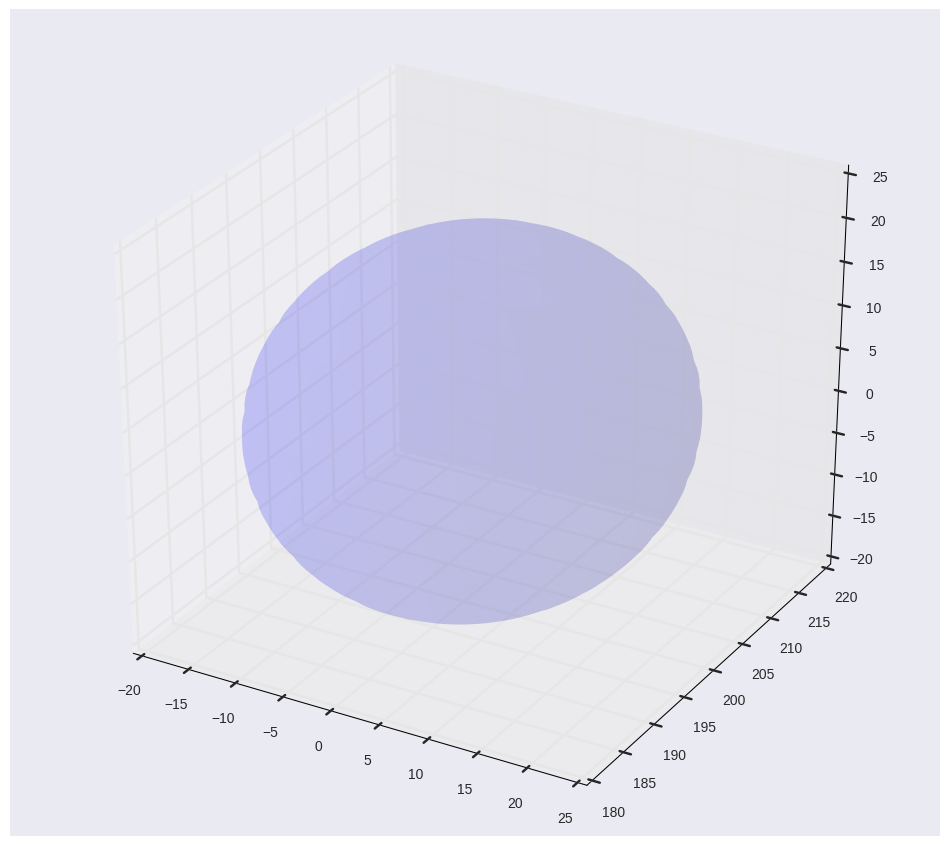

In [38]:
fig = plt.figure(figsize=(12,12), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

def sphere(r,center):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    return x+center[0],y+center[1],z+center[2]
a = sphere(20.,[1,200,1])

ax.plot_surface(a[0], a[1], a[2],  rstride=4, cstride=4, color='b',
                linewidth=0, alpha=0.1)

